In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler

# Functions

**EN**  
The functions defined below are used extensively in the Machine Learning part of the project. They are mainly performing n-fold cross-validation to assess how well the model generalizes the information and to avoid overfitting and underfitting.  Docstrings are provided for each function.  
**FR**  
Les fonctions définies ci-dessous sont largement utilisées dans la partie du projet consacrée à l'apprentissage automatique. Elles effectuent principalement une validation croisée n-fold pour évaluer dans quelle mesure le modèle généralise l'information et pour éviter l'overfitting et l'underfitting.  Une documentation est fournie pour chaque fonction.

In [10]:
def filter_outliers(data):
    """
    Filter outliers from a dataset based on the interquartile range method.

    Args:
    data (pandas.DataFrame): A dataframe with a column named 'prix' representing the numerical values to be filtered.

    Returns:
    pandas.DataFrame: A filtered dataframe with rows that have values within 1.5 times the interquartile range (IQR) 
    of the median of 'prix'.
    """
    q1_prix, q2_prix, q3_prix, q4_prix = data.prix.quantile([0.25, 0.5, 0.75, 1])
    iqr_prix = q3_prix - q1_prix
    lower_prix = q1_prix - 1.5*iqr_prix
    upper_prix = q3_prix + 1.5*iqr_prix
    data_filtered = data.query('prix>=@lower_prix and prix<=@upper_prix')
    return data_filtered

def randomized_search(estimator_, X_train_, y_train_, param_grid_, cv_, verbose_, 
                      n_jobs_, n_iter_, scoring_='neg_mean_squared_error', 
                      random_state=1, error_score='raise'):
    """
    Perform a randomized search over hyperparameters for a given estimator using cross-validation.

    Args:
    estimator_ (estimator object): An estimator object to optimize its hyperparameters.
    X_train_ (array-like or sparse matrix): Training data to fit the estimator.
    y_train_ (array-like): Target values corresponding to X_train_.
    param_grid_ (dict): Dictionary with hyperparameters to optimize and their possible values.
    cv_ (int, cross-validation generator, or an iterable): Determines the cross-validation splitting strategy.
    verbose_ (int): Controls the verbosity of the search.
    n_jobs_ (int): Number of jobs to run in parallel.
    n_iter_ (int): Number of parameter settings that are sampled.
    scoring_ (str): Scoring metric to use for evaluating the best hyperparameters. Default is 'neg_mean_squared_error'.
    random_state (int): Random state for reproducibility.
    error_score (str or numeric): Value to assign to the score if an error occurs while fitting the estimator.

    Returns:
    tuple: The best estimator and its corresponding hyperparameters found by the search.

    """
    estimator_grid = RandomizedSearchCV(estimator=estimator_, param_distributions=param_grid_,
                       cv=cv_, scoring=scoring_, error_score='raise',
                       verbose=verbose_, n_jobs=n_jobs_, n_iter=n_iter_, random_state=seed)
    estimator_grid.fit(X_train_, y_train_)
    return estimator_grid.best_estimator_, estimator_grid.best_params_

def cross_val_rmse_(model_, X_train_, y_train_, cv_, scoring_='neg_mean_squared_error'):
    """
    Calculate the root mean squared error (RMSE) of a model using cross-validation.

    Args:
    model_ (estimator object): An estimator object to evaluate its performance.
    X_train_ (array-like or sparse matrix): Training data to fit the estimator.
    y_train_ (array-like): Target values corresponding to X_train_.
    cv_ (int, cross-validation generator, or an iterable): Determines the cross-validation splitting strategy.
    scoring_ (str): Scoring metric to use for evaluating the estimator. Default is 'neg_mean_squared_error'.

    Returns:
    float: The RMSE score of the model using cross-validation.

"""
    model_cv_scores = cross_val_score(model_, X_train_, y_train_, cv=cv_, scoring=scoring_)
    model_rmse = np.sqrt(-model_cv_scores.mean())
    return model_rmse

def cross_val_rmse_score_printer(models, n_folds, X_train, y_train):
    """
    Calculate and print the cross-validation RMSE scores of a dictionary of models.

    Args:
    models (dict): A dictionary where the keys are strings representing the name of each model and the values are estimator objects to evaluate their performance.
    n_folds (int): Number of folds to use in cross-validation.
    X_train (array-like or sparse matrix): Training data to fit the estimator.
    y_train (array-like): Target values corresponding to X_train.

    Returns:
    dict: A dictionary with the cross-validation RMSE scores of each model.

    """
    models_rmses = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_rmse = cross_val_rmse_(model, X_train, y_train, cv_=n_folds)
        models_rmses[name] = model_rmse
    for key, value in models_rmses.items():
        print(f"\033[1m{key}\033[0m cross-validation RMSE: \033[1m{value:.2f}\033[0m")
    return models_rmses

# Load the data

In [11]:
data = pd.read_csv("real_estate_PML.csv")
data.head()
keys = ['Très Petit', 'Petit', 'Moyen', 'Grand', 'Très Grand' ]
values = [1,2,3,4,5]
mapped_dict = dict(zip(keys, values))

# Outliers removal

**EN**  
While certain models like Random Forest and decision-based trees perform reasonably well without scaling or preprocessing the data, here we'll be using a mix of models. Therefore we removed outliers before proceeding with the model. An important step was to treat outliers separately: An outlier in Marseille will not be an outlier in Paris, considering the price difference for the real estate market in these 3 different cities.  
**FR**  
Alors que certains modèles comme Random Forest et les arbres décisionnels fonctionnent raisonnablement bien sans mise à l'échelle ni prétraitement des données, nous utiliserons ici un mélange de modèles. C'est pourquoi nous avons supprimé les valeurs aberrantes avant de procéder à l'élaboration du modèle. Une étape importante a consisté à traiter les valeurs aberrantes séparément : Une valeur aberrante à Marseille ne sera pas une valeur aberrante à Paris, compte tenu de la différence de prix sur le marché immobilier dans ces trois villes différentes. 


In [12]:
paris, lyon, mrs = data.loc[data['ville']=='Paris',].copy(), data.loc[data['ville']=='Lyon',].copy(), data.loc[data['ville']=='Marseille',].copy()
paris.shape, lyon.shape, mrs.shape

((2921, 8), (2176, 8), (876, 8))

In [13]:
paris_filtered = filter_outliers(paris)
lyon_filtered = filter_outliers(lyon)
mrs_filtered = filter_outliers(mrs)


In [14]:
paris_filtered.shape, lyon_filtered.shape, mrs_filtered.shape

((2691, 8), (2053, 8), (798, 8))

In [15]:
df = pd.concat([paris_filtered, lyon_filtered, mrs_filtered], axis=0, ignore_index=True)
data.shape, df.shape

((5973, 8), (5542, 8))

# Dummies
**EN**  
We need to encode our categorical variables. We will use `pd.get_dummies()` function.  
**FR**  
Pour utiliser les données qu'on a dans un modèle de Machine Learning, il faut d'abord encoder les variables catégorielles, car les modèles ne comprennent pas les variables catégorielles.

In [16]:
dummy = pd.get_dummies(df['ville'], dtype=float)
df = pd.concat([dummy, df], axis=1).drop(['type_l', 'prix_m2', 'ville'], axis=1)

# Data split and scaling

**EN**  
We will be using the prebuilt function from the sklearn library: train_test_split to split our data into a training set, where we train and evaluate the model performance and then perform the final predictions and evaluations on the test data. A random seed will be chosen for reproducibility.   
**FR**  
Nous utiliserons la fonction préconstruite de la bibliothèque sklearn : train_test_split pour diviser nos données en un ensemble d'entraînement, où nous entraînons et évaluons les performances du modèle, puis effectuons les prédictions et évaluations finales sur les données de test. Une *seed* aléatoire sera choisie pour la reproductibilité. 

In [17]:
features = [col for col in df.columns if col != 'prix']
seed = 4
X_train, X_test, y_train, y_test = train_test_split(df[features].values, df.prix.values, test_size=0.1, random_state=seed)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Establish base models

**EN**  
We established the base models, with default hyperparameters to perform a first benchmark. Here a 10-fold cross-validation was used to assess model performance.  
**FR**  
Nous avons établi les modèles de base, avec des hyperparamètres par défaut, pour réaliser un premier benchmark. Ici, une validation croisée 10-fold a été utilisée pour évaluer la performance du modèle.

In [19]:
lreg = LinearRegression()
ridge = Ridge(alpha=0.5)
dt = DecisionTreeRegressor(random_state=seed)
rf = RandomForestRegressor(random_state=seed)
knr = KNeighborsRegressor()

In [20]:
# RMSE on non-scaled features
models = {'Linear Regresion': LinearRegression(),
          'Ridge': Ridge(alpha=0.5),
          'Decision Tree Regressor': DecisionTreeRegressor(random_state=seed),
          'Random Forest Regressor': RandomForestRegressor(random_state=seed),
          'KNeighbors Regressor': KNeighborsRegressor()}
non_scaled_10cv_rmse = cross_val_rmse_score_printer(models, n_folds=10, X_train=X_train, y_train=y_train)

Linear Regresion cross-validation RMSE: 178268.32
Ridge cross-validation RMSE: 178268.01
Decision Tree Regressor cross-validation RMSE: 154060.78
Random Forest Regressor cross-validation RMSE: 124380.12
KNeighbors Regressor cross-validation RMSE: 187944.40


**EN**  
Same models, but with scaled features.  
**FR**  
Les mêmes modèles mais avec des features normalisés.

In [21]:
# RMSE on scaled features
scaled_10cv_rmse = cross_val_rmse_score_printer(models, n_folds=10, X_train=X_train_scaled, y_train=y_train)

Linear Regresion cross-validation RMSE: 178265.61
Ridge cross-validation RMSE: 178267.91
Decision Tree Regressor cross-validation RMSE: 153586.20
Random Forest Regressor cross-validation RMSE: 124240.98
KNeighbors Regressor cross-validation RMSE: 134269.60


**EN**  
The only model that benefits a lot from scaling is the K Nearest Neighbors model. It is quite obvious, as the model uses by default distances to train and assign the weights. When the features are not scaled, the model performs well, as there is a big difference in the scale of distances. (Prices are in the Millions or Euros, while the number of bedrooms - 0 to 15). Feature scaling is usually important in other models too, like Linear Regression, Neural Networks with certain activation functions, but in this case our models performed reasonably well without scaling.  
**FR**  
Le seul modèle qui bénéficie d'une mise à l'échelle est le modèle des plus proches voisins (K Nearest Neighbors). C'est assez évident, car le modèle utilise par défaut les distances pour l'apprentissage et l'attribution des poids. Lorsque les caractéristiques ne sont pas mises à l'échelle, le modèle donne de bons résultats, car il existe une grande différence dans l'échelle des distances. (Les prix sont exprimés en millions ou en euros, tandis que le nombre de chambres est compris entre 0 et 15). La mise à l'échelle des caractéristiques est généralement importante dans d'autres modèles, comme la régression linéaire, les réseaux neuronaux avec certaines fonctions d'activation, mais dans ce cas, nos modèles fonctionnent raisonnablement bien sans mise à l'échelle.

# Add new feature

**EN**  
We'll add a new feature and see if our model RMSE improves. If it doesn't than we may need to leave the features as they are, to avoid overfitting.  
**FR**  
Nous allons ajouter une nouvelle fonctionnalité et voir si le RMSE de notre modèle s'améliore. Si ce n'est pas le cas, nous devrons peut-être laisser les caractéristiques telles quelles, afin d'éviter un surajustement.

In [23]:
containers = [0,20,40,80,160,df['surface_m2'].max()]
df['largeur'] = pd.cut(df['surface_m2'], containers, labels = keys)
df['largeur']=df['largeur'].map(mapped_dict)
df.head()

,Lyon,Marseille,Paris,arr,n_pieces,n_chambres,surface_m2,prix,largeur
0,0.0,0.0,1.0,17,3.0,1.0,51.84,535000.0,3
1,0.0,0.0,1.0,15,3.0,2.0,40.77,470000.0,3
2,0.0,0.0,1.0,13,2.0,1.0,39.00,385000.0,2
3,0.0,0.0,1.0,13,2.0,1.0,36.03,383000.0,2
4,0.0,0.0,1.0,10,2.0,1.0,40.70,399000.0,3


In [24]:
new_features = [col for col in df.columns if col!='prix']
X_new = df[new_features].values
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, df.prix.values, test_size=0.1, random_state=seed)
X_new_train_scaled = scaler.fit_transform(X_new_train)
X_new_test_scaled = scaler.transform(X_new_test)

In [25]:
scaled_10cv_rmse_new_features = cross_val_rmse_score_printer(models, n_folds=10, X_train=X_new_train_scaled, y_train=y_new_train)

Linear Regresion cross-validation RMSE: 175814.33
Ridge cross-validation RMSE: 175813.67
Decision Tree Regressor cross-validation RMSE: 153540.37
Random Forest Regressor cross-validation RMSE: 124220.22
KNeighbors Regressor cross-validation RMSE: 135292.66


## Comment on results
**EN**  
The RMSE worsened, indicating that the new feature should not be used and actually contributes negatively to our model.   
**FR**  
Le RMSE s'est aggravé, ce qui indique que la nouvelle caractéristique ne devrait pas être utilisée et qu'elle contribue en fait négativement à notre modèle. 


# Hyper parameter Tuning
**EN**  
Hyperparameters are configuration variables that control the behavior and performance of machine learning models. It is an important step in establishing a good model as some models, especially tree-based models don't have the most optimal hyperparameters.   
**FR**  
Les hyperparamètres sont des variables de configuration qui contrôlent le comportement et les performances des modèles d'apprentissage automatique. Il s'agit d'une étape importante dans l'établissement d'un bon modèle, car certains modèles, en particulier les modèles à base d'arbres, n'ont pas les hyperparamètres les plus adaptés. 

In [26]:
ridge_param = {
    'alpha':[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 50],
    'solver':['svd', 'cholesky', 'saga']}

dt_params = {
    'max_depth':range(1,20),
    'min_samples_leaf':[0.1, 0.2, 0.3, 0.5, 0.8, 1],
    'min_samples_split':[2, 3, 5, 10]}

rf_params = {
    'bootstrap':[True, False],
    'ccp_alpha':[0.2, 0.4, 0.6, 0.8, 1],
    'max_depth':[1, 2, 4, 6, 8, 10, 12, 14, 15],
    'min_samples_leaf':[0.2, 0.4, 0.6, 0.8, 1],
    'n_estimators':[20, 50, 100, 250, 500]}

knr_params = {
    'algorithm':['ball_tree', 'kd_tree'],
    'leaf_size':[10,20,30],
    'n_neighbors':[1,3,5,10,15]}
params_list = [ridge_param, dt_params, rf_params, knr_params]

**EN**  
First we establish a grid of parameters to search for, then we use a Randomized Search to look for the best hyperparameters. Ideally we would use Grid Search CV, but the computation time gets exponentially bigger with more hyperparameters to explore.  
**FR**  
Tout d'abord, nous établissons une grille de paramètres à rechercher, puis nous utilisons une recherche aléatoire pour trouver les meilleurs hyperparamètres. L'idéal serait d'utiliser le CV de recherche en grille, mais le temps de calcul augmente de façon exponentielle avec le nombre d'hyperparamètres à explorer.

In [27]:
new_models = {
          'Ridge': Ridge(alpha=0.5),
          'Decision Tree Regressor': DecisionTreeRegressor(random_state=25),
          'Random Forest Regressor': RandomForestRegressor(random_state=25),
          'KNeighbors Regressor': KNeighborsRegressor()}

best_model_dict = {}
best_hyper_params = []

for (key,val), parameters in zip(new_models.items(), params_list):
    best_model, model_best_hp = randomized_search(val, X_train_scaled, y_train, param_grid_=parameters, cv_=5, verbose_=0, n_jobs_=-1, n_iter_= 150)
    best_model_dict[key] = best_model
    model_best_hp['model'] = key
    best_hyper_params.append(model_best_hp)

C:\NKT\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=150. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\NKT\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=150. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## Explore Gradient Boosting and Adaptive Boosting for a stacking model
**EN**  
Gradient Boosting and AdaBoost (Adaptive Boosting) are two popular ensemble learning techniques used in machine learning for building predictive models.Gradient Boosting is a technique that combines multiple weak models (usually decision trees) into a strong model. The algorithm works by iteratively training decision trees on the residuals (or errors) of the previous model. In each iteration, the algorithm attempts to minimize the loss function by adjusting the weights of the training examples. The final model is a weighted sum of the individual trees, where each tree is weighted based on its contribution to the overall performance.  

AdaBoost, on the other hand, is a similar technique that also combines multiple weak models into a strong model. The key difference is that AdaBoost assigns weights to the training examples and adjusts the weights of the examples that were incorrectly classified in the previous iteration. In each iteration, a new weak model is trained on the updated weights, and the final model is a weighted sum of the individual models.  
**FR**  

Gradient Boosting et AdaBoost (Adaptive Boosting) sont deux techniques d'apprentissage d'ensemble populaires utilisées dans l'apprentissage automatique pour construire des modèles prédictifs. Le Gradient Boosting est une technique qui combine plusieurs modèles faibles (généralement des arbres de décision) en un modèle fort. L'algorithme fonctionne en formant itérativement des arbres de décision sur les résidus (ou erreurs) du modèle précédent. À chaque itération, l'algorithme tente de minimiser la fonction de perte en ajustant les poids des exemples d'apprentissage. Le modèle final est une somme pondérée des arbres individuels, où chaque arbre est pondéré en fonction de sa contribution à la performance globale.

AdaBoost, quant à lui, est une technique similaire qui combine également plusieurs modèles faibles en un modèle fort. La principale différence réside dans le fait qu'AdaBoost attribue des poids aux exemples d'apprentissage et ajuste les poids des exemples qui ont été mal classés lors de l'itération précédente. À chaque itération, un nouveau modèle faible est formé sur la base des poids mis à jour, et le modèle final est une somme pondérée des modèles individuels.


In [35]:
gb = GradientBoostingRegressor(random_state=seed)
ada = AdaBoostRegressor(random_state=seed)
best_hyper_params

[{'solver': 'cholesky', 'alpha': 5, 'model': 'Ridge'},
 {'min_samples_split': 3,
  'min_samples_leaf': 1,
  'max_depth': 8,
  'model': 'Decision Tree Regressor'},
 {'n_estimators': 100,
  'min_samples_leaf': 1,
  'max_depth': 12,
  'ccp_alpha': 0.2,
  'bootstrap': True,
  'model': 'Random Forest Regressor'},
 {'n_neighbors': 5,
  'leaf_size': 10,
  'algorithm': 'ball_tree',
  'model': 'KNeighbors Regressor'}]

In [36]:
boost_models = {
    'Gradient Boosting Regressor': gb,
    'Ada Boosting':ada}

gb_params = {
    'learning_rate':[0.01, 0.05, 0.1, 0.2],
    'ccp_alpha':[0.01, 0.05, 0.1, 0.2, 0.5],
    'max_depth':range(2,11),
    'min_weight_fraction_leaf':[0.01, 0.05, 0.1, 0.2],
    'n_estimators':range(10,210,10)}

dt_base = DecisionTreeRegressor(random_state=seed, max_depth=3)
dt_best = DecisionTreeRegressor(max_depth=8, min_samples_split=3, random_state=seed)

ada_params = {
    'estimator':[dt_base, dt_best],
    'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5],
    'n_estimators':range(10,110, 10)}

boosting_param_list = [gb_params, ada_params]
best_boost_dict = {}
best_boost_hp = []


for (key,val), parameters in zip(boost_models.items(), boosting_param_list):
    best_model, model_best_hp = randomized_search(val, X_train_scaled, y_train, param_grid_=parameters, cv_=10, verbose_=0, n_jobs_=-1, n_iter_= 50)
    best_boost_dict[key] = best_model
    model_best_hp['model']=key
    best_boost_hp.append(model_best_hp)

In [38]:
all_models_dict = {}
for key, value in best_boost_dict.items():
    all_models_dict[key]=value
for key, value in best_model_dict.items():
    all_models_dict[key]=value

**EN**  
In the previous cells, we performed a grid search to find the optimal hyperparameters for tree-based regressors, simple linear models, and for Gradient Boosting and AdaBoosting. We then assigned the best model hyperparameters and the best models in a list, and dictionary, respectively. We'll then use the best models in a stacking model which is an ensemble learning technique that combines multiple individual regression models to improve the overall predictive performance of the model. The idea behind stacking is to use the output of the base models as input to a meta-regressor, which learns to combine the base models' predictions into a final prediction.  
**FR**  
Dans les cellules précédentes, nous avons effectué une recherche en grille pour trouver les hyperparamètres optimaux pour les régresseurs arborescents, les modèles linéaires simples, ainsi que pour le Gradient Boosting et l'AdaBoosting. Nous avons ensuite assigné les meilleurs hyperparamètres de modèle et les meilleurs modèles dans une liste et un dictionnaire, respectivement. Nous utiliserons ensuite les meilleurs modèles dans un modèle d'empilement (stacking model), qui est une technique d'apprentissage d'ensemble combinant plusieurs modèles de régression individuels afin d'améliorer les performances prédictives globales du modèle. L'idée derrière l'empilement est d'utiliser la sortie des modèles de base comme entrée d'un méta-régresseur, qui apprend à combiner les prédictions des modèles de base en une prédiction finale.

**EN**  
We then use the best models to see if there is improvement, which indeed is present, but not by a great margin.  
**FR**  
Nous utilisons ensuite les meilleurs modèles pour voir s'il y a une amélioration, ce qui est effectivement le cas, mais pas dans une large mesure.  


In [39]:
all_models_rmse_10_folds = cross_val_rmse_score_printer(all_models_dict, n_folds=10, X_train=X_train_scaled, y_train=y_train)

Gradient Boosting Regressor cross-validation RMSE: 124393.41
Ada Boosting cross-validation RMSE: 126334.97
Ridge cross-validation RMSE: 178265.22
Decision Tree Regressor cross-validation RMSE: 136156.93
Random Forest Regressor cross-validation RMSE: 122304.45
KNeighbors Regressor cross-validation RMSE: 134350.64


## Stacking Regressor

In [41]:
level_0 = [('GBR', all_models_dict['Gradient Boosting Regressor']), ('ADA', all_models_dict['Ada Boosting']), ('RF', all_models_dict['Random Forest Regressor'])]
level_1 = lreg
stack_model = StackingRegressor(estimators=level_0, final_estimator=level_1, cv=10)


In [42]:
all_models_dict

{'Gradient Boosting Regressor': GradientBoostingRegressor(ccp_alpha=0.5, learning_rate=0.2, max_depth=9,
                           min_weight_fraction_leaf=0.01, n_estimators=140,
                           random_state=4),
 'Ada Boosting': AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=8,
                                                   min_samples_split=3,
                                                   random_state=4),
                   learning_rate=0.5, n_estimators=80, random_state=4),
 'Ridge': Ridge(alpha=5, solver='cholesky'),
 'Decision Tree Regressor': DecisionTreeRegressor(max_depth=8, min_samples_split=3, random_state=25),
 'Random Forest Regressor': RandomForestRegressor(ccp_alpha=0.2, max_depth=12, random_state=25),
 'KNeighbors Regressor': KNeighborsRegressor(algorithm='ball_tree', leaf_size=10)}

In [43]:
stack_rmse = cross_val_rmse_(stack_model, X_train_scaled, y_train, 10, scoring_='neg_mean_squared_error')
print(f"Stacking Regressor RMSE: \033[1m{stack_rmse}\033[0m")

Stacking Regressor RMSE: 120561.77620917767


**EN**  
We indeed see a 2000 improvement on the RMSE score. We'll see if the model holds-up its leading position on the test dataset.  
**FR**  
Nous constatons en effet une amélioration de 2000 du score RMSE. Nous verrons si le modèle maintient sa position de leader sur l'ensemble de données de test


**EN**  
We're going to use the 3 best performing models for the final evaluation on both the train and test sets and draw the conclusions.  
**FR**  
Nous allons utiliser les 3 modèles les plus performants pour l'évaluation finale sur les ensembles de formation et de test et tirer les conclusions.  

In [63]:
final_models = {
    'Random Forest': all_models_dict['Random Forest Regressor'],
    'Gradient Boost': all_models_dict['Gradient Boosting Regressor'],
    'Stacking': stack_model
}

In [50]:
rmses_test = {}
rmses_train = {}
y_predicts = {}
y_train_predicts = {}
for name, model in final_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)
    rmse_y = mean_squared_error(y_test, y_pred, squared=False)
    rmse_y_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmses_test[name] = rmse_y
    rmses_train[name] = rmse_y_train
    y_predicts[name] = y_pred
    y_train_predicts[name] = y_train_pred

for key, value in rmses_test.items():
    print(f"\033[1m{key}\033[0m RMSE on test data: \033[1m{value}\033[0m")
print(f"{'-'*50}")
for key, value in rmses_train.items():
     print(f"\033[1m{key}\033[0m RMSE on train data: \033[1m{value}\033[0m")

Random Forest RMSE on test data: 110301.36799278643
Gradient Boost RMSE on test data: 118130.82089492359
Stacking RMSE on test data: 111372.33032507873
--------------------------------------------------
Random Forest RMSE on train data: 70384.57559745459
Gradient Boost RMSE on train data: 102369.97286098977
Stacking RMSE on train data: 82092.64069230294


**EN**  
After analyzing the train and test RMSEs we can see that the best-performing model on the test dataset is still the stacking model, since the difference in train and test RMSEs is the smallest for Gradient Boosting, it would be a winner here - it generalizes the best.  
**FR**  
Après avoir analysé les RMSE de formation et de test, nous pouvons voir que le modèle le plus performant sur l'ensemble de données de test est toujours le modèle d'empilage, puisque la différence entre les RMSE de formation et de test est la plus faible pour le Gradient Boosting, il devrait être le gagnant ici - il généralise le mieux. 

In [51]:
for key, value in y_predicts.items():
    y_predicts[key]=value.tolist()
df_predicts = pd.DataFrame(y_predicts)
df_predicts['y_test'] = y_test
df_predicts.columns = df_predicts.columns.str.lower().str.replace(" ","_")

In [52]:
for key, value in y_train_predicts.items():
    y_train_predicts[key]=value.tolist()

In [53]:
df_train_predicts = pd.DataFrame(y_train_predicts)
df_train_predicts['y_test'] = y_train
df_train_predicts.columns = df_train_predicts.columns.str.lower().str.replace(" ","_")

In [54]:
df_train_predicts.head()

,random_forest,gradient_boost,stacking,y_test
0,634243.259602,641553.030535,645291.657396,598000.0
1,362413.282627,365960.455876,363537.387639,370000.0
2,309095.568952,310996.095565,306983.776271,290000.0
3,366221.625857,371030.089156,369306.083125,364000.0
4,358784.241380,430046.114602,391630.880412,370000.0


**EN**  
Here we have a dataframe that shows the true values and the predicted ones for the best 3 performing models.  
**FR**  
Nous avons ici un cadre de données qui montre les valeurs réelles et les valeurs prédites pour les 3 modèles les plus performants. 

In [55]:
for col in df_predicts.columns:
    df_predicts[col] = np.round(df_predicts[col], 2)
    df_train_predicts[col] = np.round(df_train_predicts[col], 2)

In [56]:
cols = [col for col in df_predicts.columns if col!='y_test']
for col in cols:
    col_err = col+'_error'
    col_rmse = col+'_rmse'
    df_predicts[col_err] = np.abs(df_predicts[col] - df_predicts['y_test'])
    df_train_predicts[col_err] = np.abs(df_train_predicts[col] - df_train_predicts['y_test'])

In [57]:
df_predicts.head()

,random_forest,gradient_boost,stacking,y_test,random_forest_error,gradient_boost_error,stacking_error
0,130253.51,118976.26,125047.78,143000.0,12746.49,24023.74,17952.22
1,560159.36,600439.39,578694.63,715000.0,154840.64,114560.61,136305.37
2,437965.01,504782.16,461790.89,661500.0,223534.99,156717.84,199709.11
3,218652.19,204301.14,211946.61,194250.0,24402.19,10051.14,17696.61
4,806680.17,826518.69,819396.95,920000.0,113319.83,93481.31,100603.05


In [58]:
df_pred_sorted = df_predicts.sort_values("y_test").reset_index(drop=True)
df_pred_sorted_first_100 = df_pred_sorted.loc[:100,]

**EN**  
Finally, we'll plot the errors made by our models for the first 100 rows.  
**FR**  
Enfin, nous tracerons les erreurs commises par nos modèles pour les 100 premières lignes. 

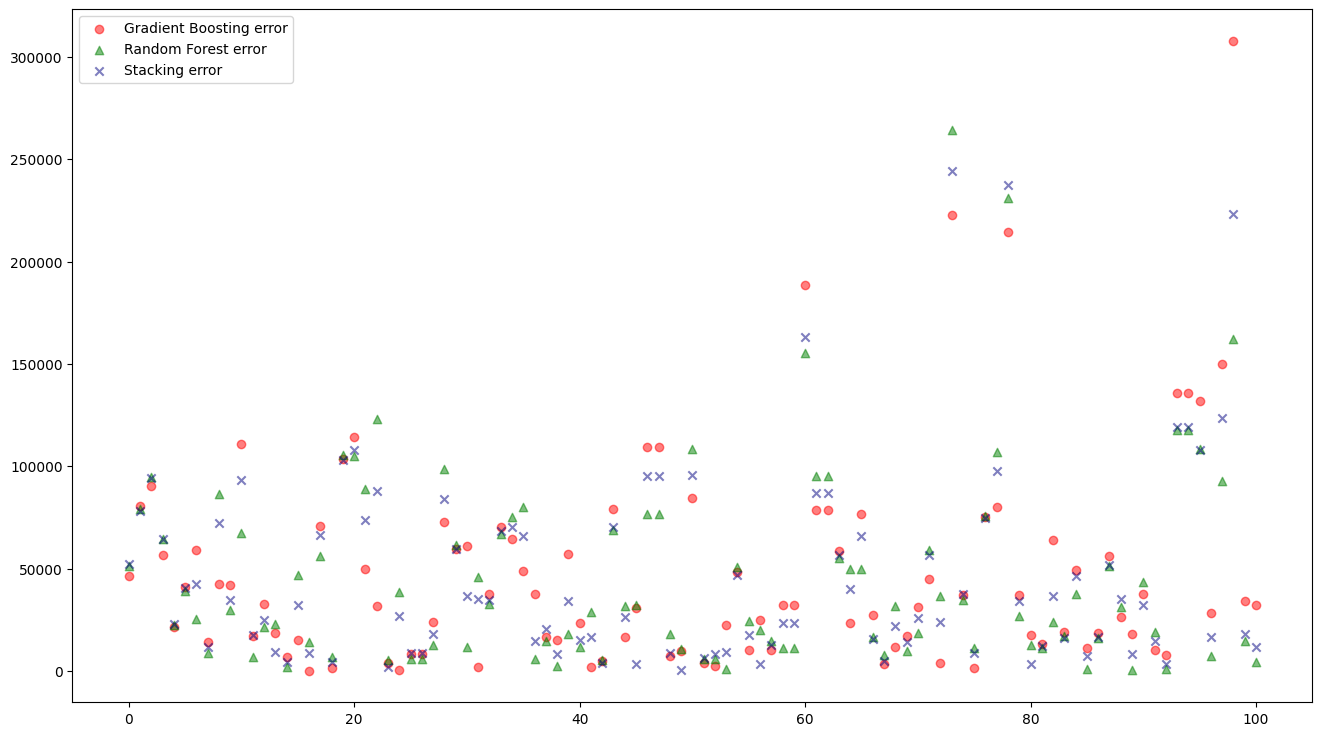

In [60]:
plt.subplots(figsize=(16,9))
plt.scatter(df_pred_sorted_first_100.index, df_pred_sorted_first_100.gradient_boost_error, label='Gradient Boosting error',
         color='red', alpha = 0.5)
plt.scatter(df_pred_sorted_first_100.index, df_pred_sorted_first_100.random_forest_error, label='Random Forest error',
         color='green', marker = '^', alpha = 0.5)
plt.scatter(df_pred_sorted_first_100.index, df_pred_sorted_first_100.stacking_error, label='Stacking error',
         color='navy', marker = 'x', alpha=0.5)
plt.legend()
plt.show()


**EN**  
Here we have a plot of the true prices (red line) and the predicted values (stacking model).  
**FR**  
Ci-dessous nous avons une représentation graphique des prix réels (ligne rouge) et des valeurs prédites (stacking model). 

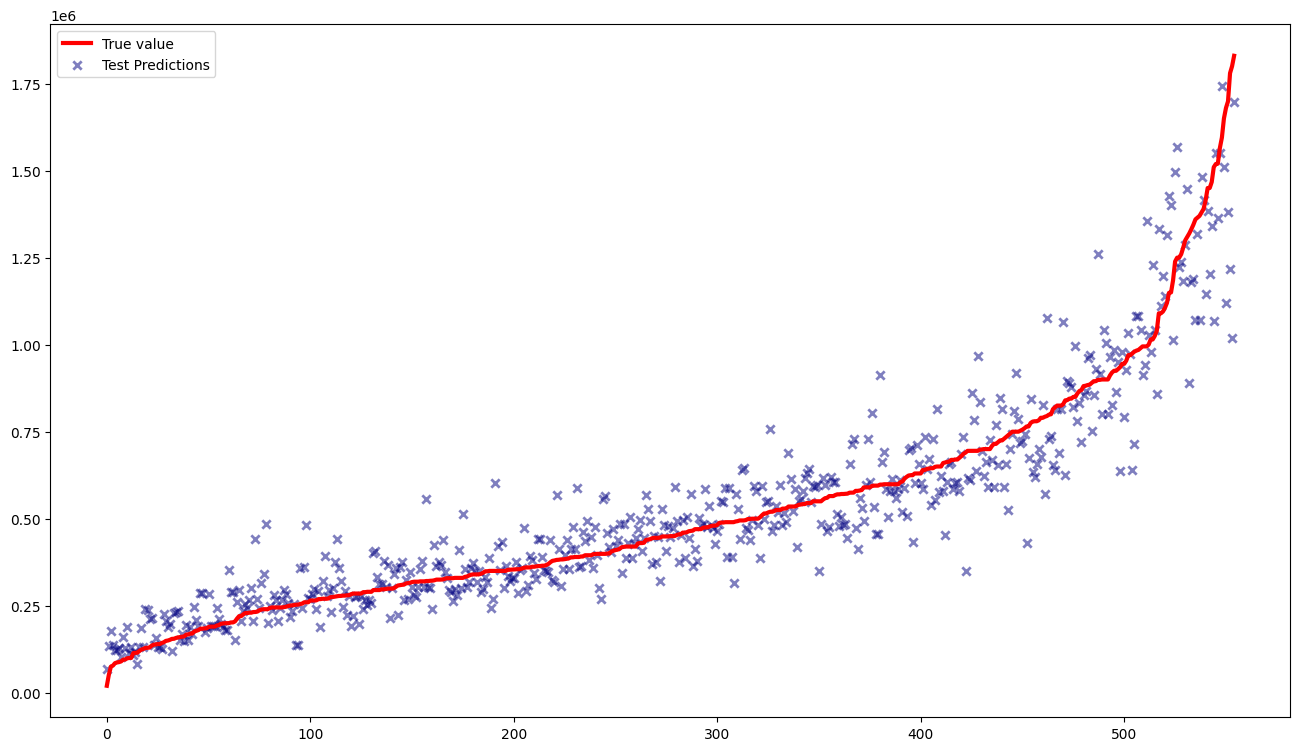

In [61]:
plt.subplots(figsize=(16,9))
plt.plot(df_pred_sorted.index, df_pred_sorted.y_test, color='red', label='True value', linewidth=3)
plt.scatter(df_pred_sorted.index, df_pred_sorted.stacking, color = 'navy', marker='x', alpha=0.5, label='Test Predictions', linewidth=2)
plt.legend()
plt.show()


In [64]:
for name, model in final_models.items():
    model.fit(X_train, y_train)
    print(f"{name} R squared: {model.score(X_test, y_test)}")

Random Forest R squared: 0.8846039654403245
Gradient Boost R squared: 0.8680433317338498
Stacking R squared: 0.8813722357295988


**EN**  
Finally we see that our models and our selected features can roughly explain between 86% and 88% of the variance in the target variable: price.  
**FR**  
Enfin, nous constatons que nos modèles et les caractéristiques que nous avons sélectionnées peuvent expliquer approximativement entre 86 % et 88 % de la variance de la variable cible : le prix.  